## Подготовка

In [52]:
# импортируем библиотеки:
import warnings
warnings.filterwarnings('ignore')

import joblib
import pandas as pd
import xgboost as xgb

from catboost import CatBoostRegressor
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
# загрузим данные:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
data.head()

num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
# проверим на наличие пропусков:
data.isna().sum()

num_orders    0
dtype: int64

In [8]:
# отсортируем индекс:
data = data.sort_index()

In [9]:
# проверим, в хронологическом ли порядке расположены даты и время:
data.index.is_monotonic_increasing

True

In [10]:
# ресемплируем данные по 1 часу:
df = data.resample('1H').sum()
df.tail()

num_orders
datetime                       
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

## Анализ

Рассмотрим, как выглядят данные.

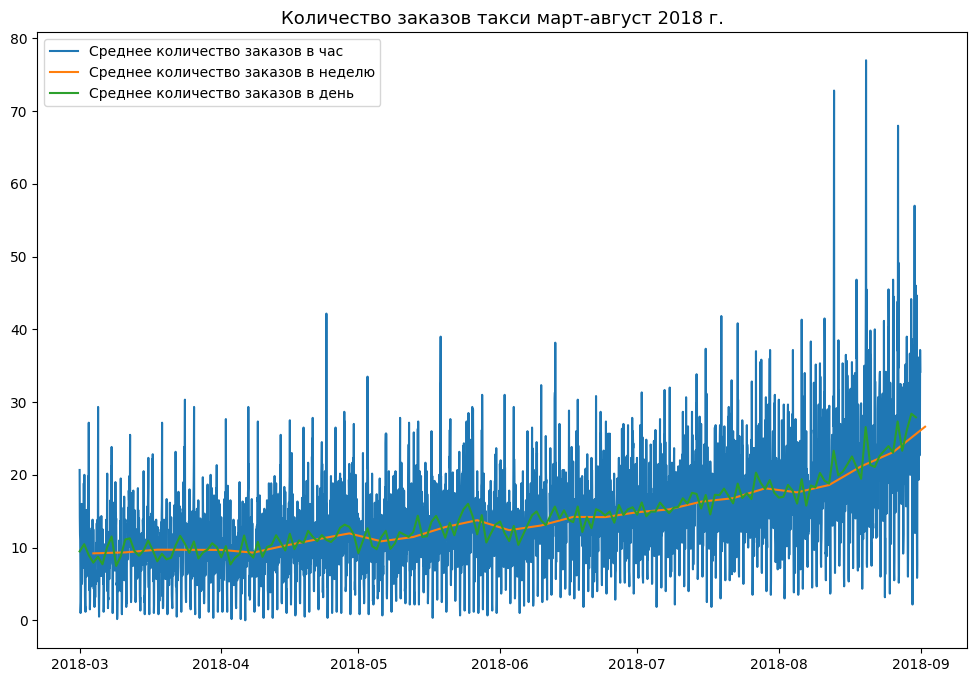

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(data.resample('1H').mean(), label='Среднее количество заказов в час')
plt.plot(data.resample('1W').mean(), label='Среднее количество заказов в неделю')
plt.plot(data.resample('1D').mean(), label='Среднее количество заказов в день')
plt.title('Количество заказов такси март-август 2018 г.', fontsize=13)
plt.legend()
plt.show()

По графику видно, что со временем все больше и больше людей пользуются услугой заказа такси, а также то, что среднее количество заказов в неделю в целом растет, но никакой закономерности не наблюдается. При этом график, отражающий количество заказов в день, свидетельствует о том, что есть пиковые часы заказа такси, а есть те, в которые происходит спад.

Изучим тренды и сезонность заказа такси.

In [12]:
# разложим временной ряд на тренд и сезонную компоненту:
decomposed = seasonal_decompose(df)

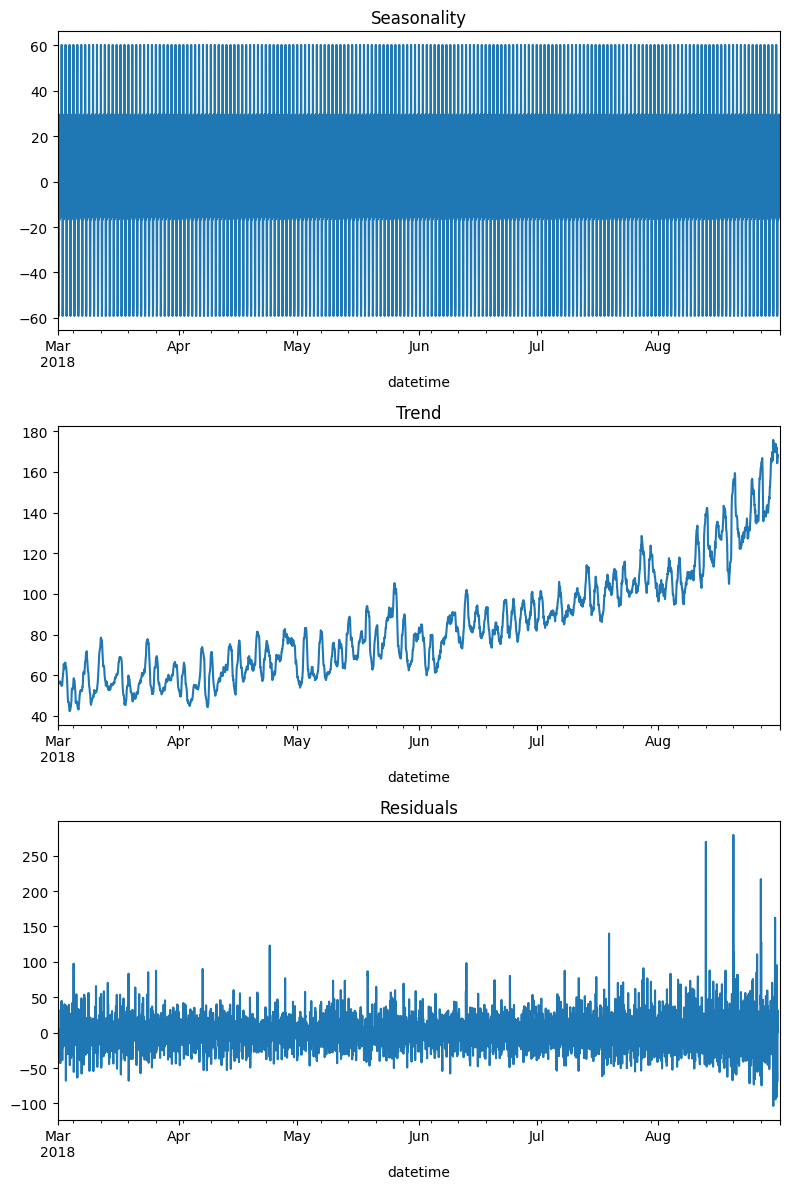

In [13]:
plt.figure(figsize=(8, 12))
plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

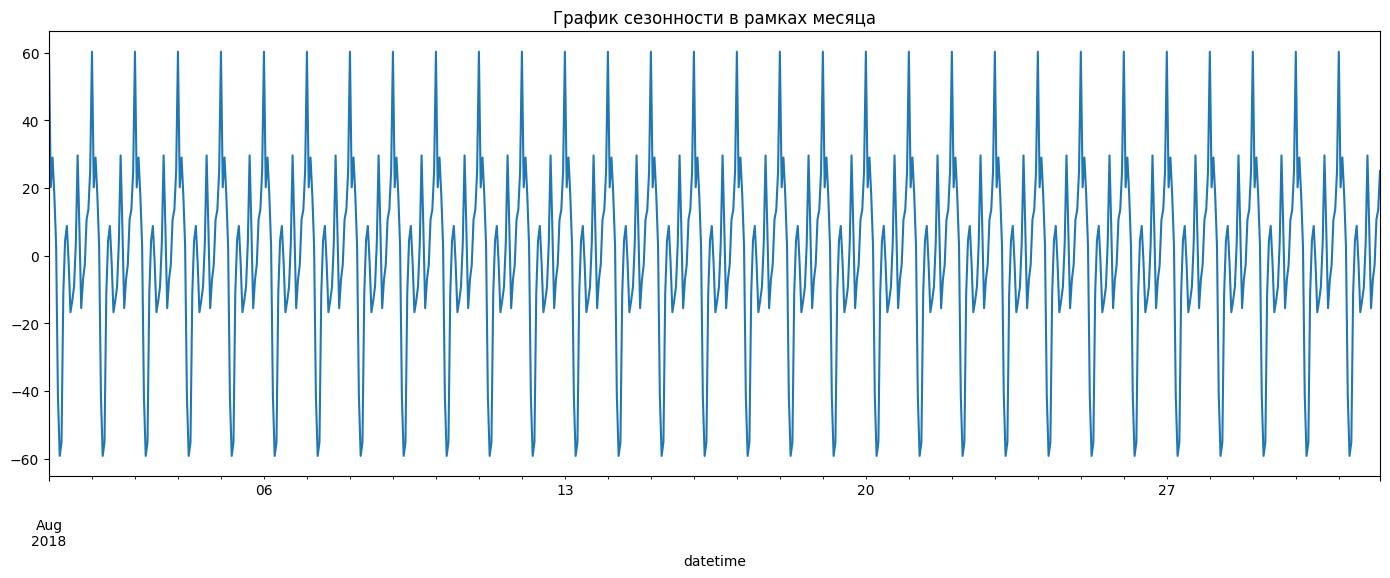

In [14]:
# построим график сезонной составляющей за август:
plt.figure(figsize=(14, 16))
plt.subplot(311)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('График сезонности в рамках месяца')
plt.tight_layout()

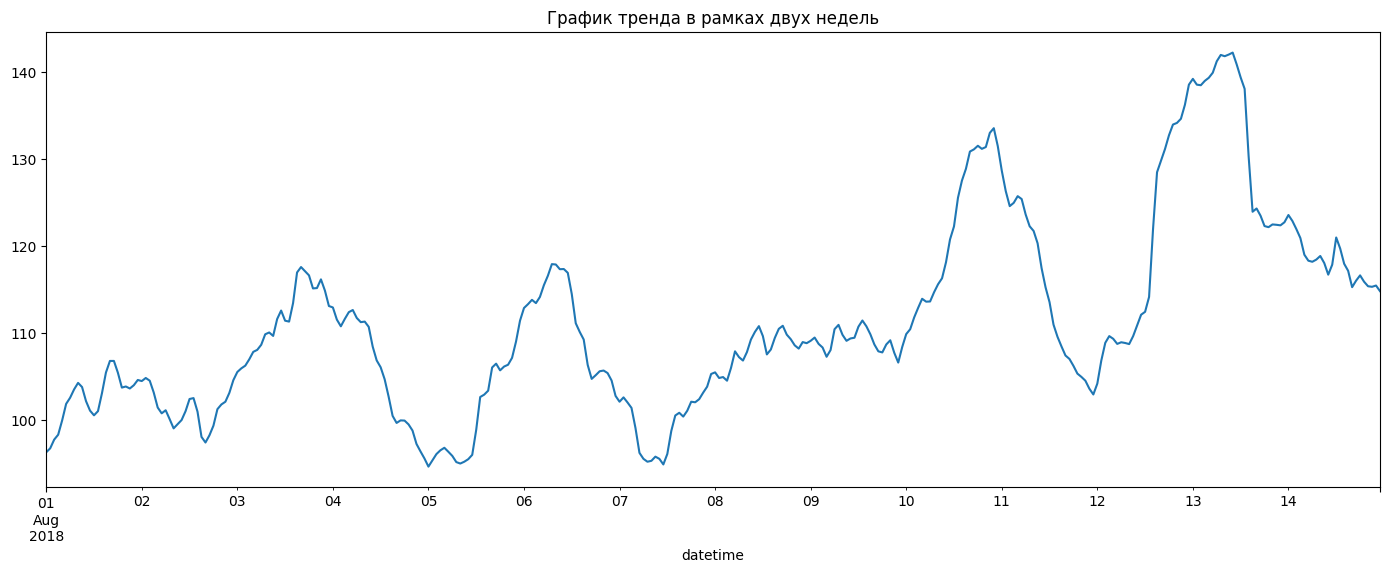

In [15]:
# построим график тренда за две недели:
plt.figure(figsize=(14, 16))
plt.subplot(311)
decomposed.trend['2018-08-01':'2018-08-14'].plot(ax=plt.gca())
plt.title('График тренда в рамках двух недель')
plt.tight_layout()

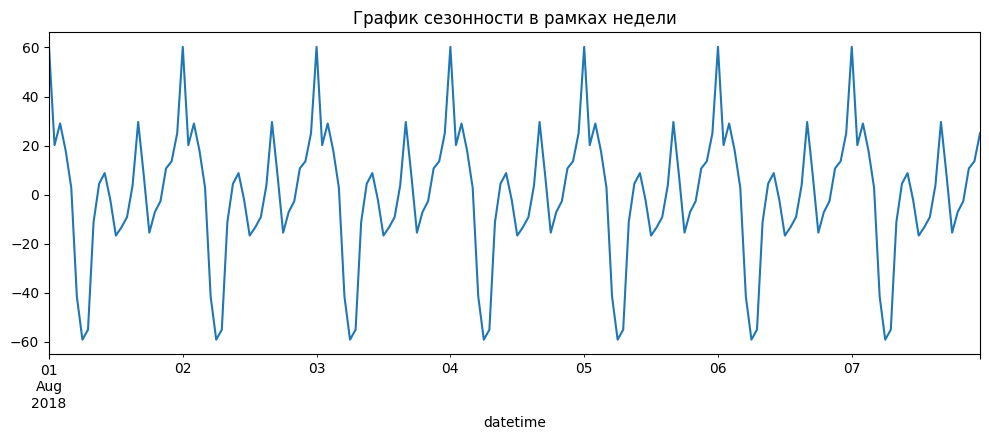

In [16]:
# построим график сезонной составляющей за неделю в августе:
plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca())
plt.title('График сезонности в рамках недели')
plt.tight_layout()

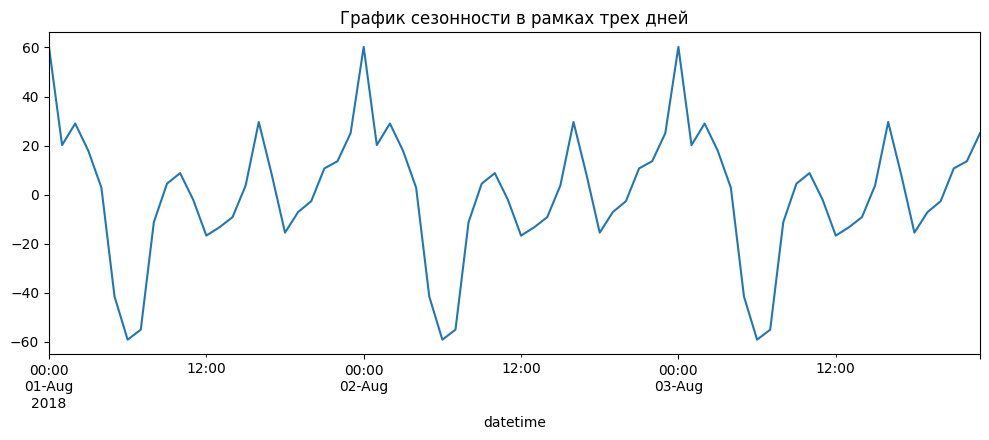

In [17]:
# построим график сезонной составляющей за три дня августе:
plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.seasonal['2018-08-01':'2018-08-03'].plot(ax=plt.gca())
plt.title('График сезонности в рамках трех дней')
plt.tight_layout()

В рамках анализа сезонности очевидна дневная периодичность. По графику видно, что больше всего заказов приходится на 12 ночи, а меньше всего - на 6 утра. Также заметно присутствие циклично-повторяющейся закономерности на графике двухнедельного тренда.

Проверим стационарность временного ряда.

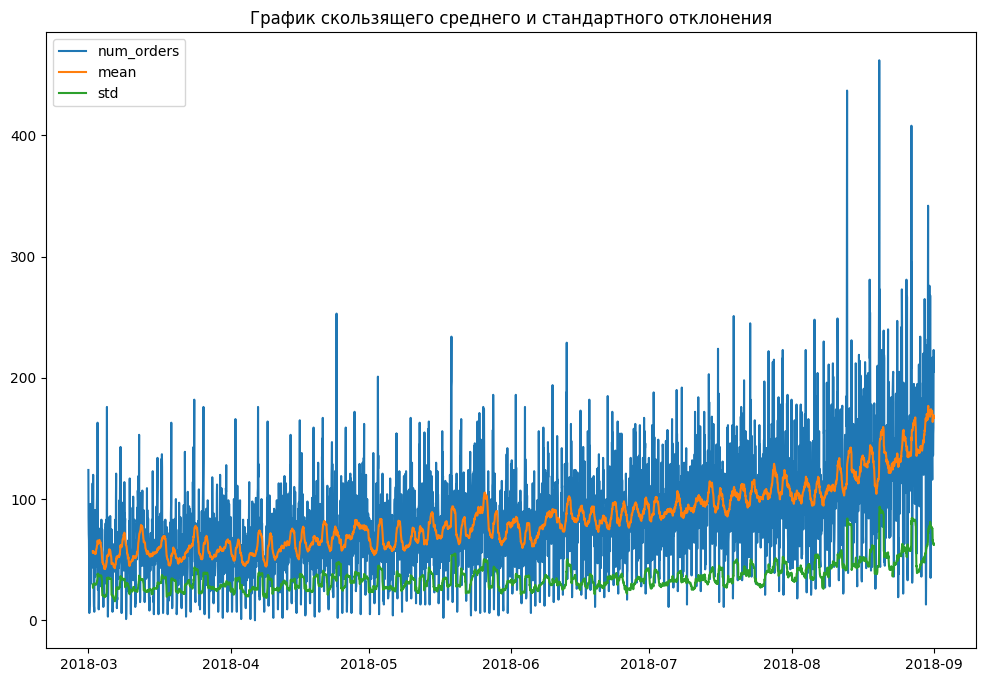

In [18]:
plt.figure(figsize=(12,8))
plt.plot(df, label='num_orders')
plt.plot(df['num_orders'].rolling(24).mean(), label='mean')
plt.plot(df['num_orders'].rolling(24).std(), label='std')
plt.title('График скользящего среднего и стандартного отклонения')
plt.legend(loc='upper left')
plt.show()

Исходный ряд нестационарен. Теперь найдем разности временного ряда — это набор разностей между соседними элементами временного ряда, т.е. из каждого значения вычитается предыдущее. Для поиска разностей временного ряда применяется метод shift(). Все значения он сдвигает вдоль временной оси на один шаг вперёд. Проверим, стационарны ли разности временного ряда.

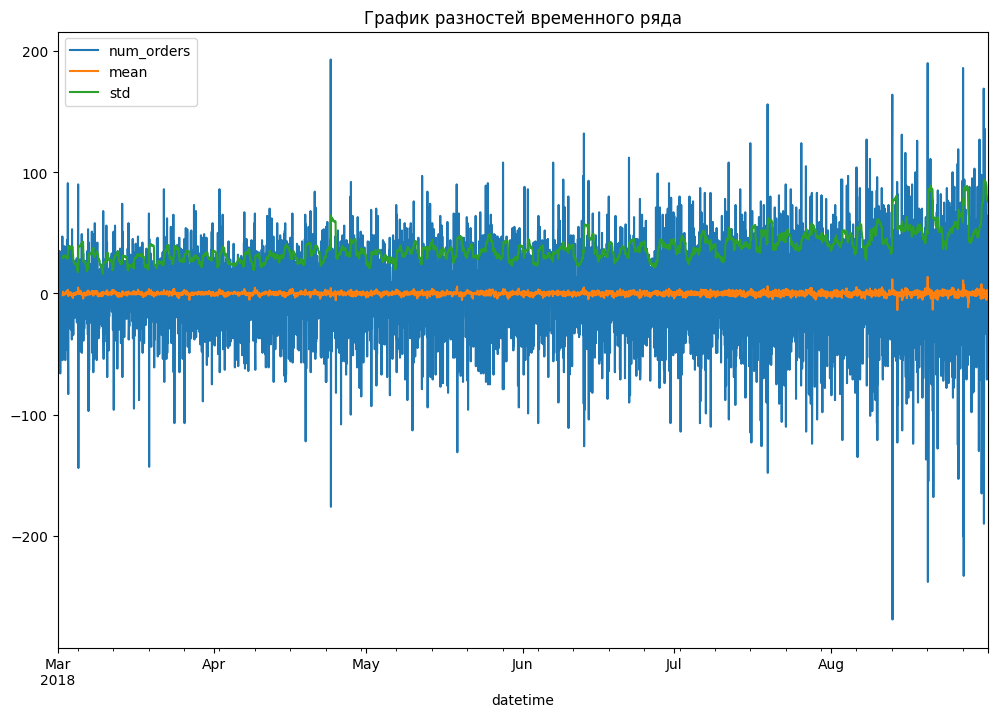

In [19]:
df_shift = df - df.shift()
df_shift['mean'] = df_shift['num_orders'].rolling(24).mean()
df_shift['std'] = df_shift['num_orders'].rolling(24).std()
df_shift.plot(figsize=(12,8))
plt.title('График разностей временного ряда')
plt.show()

По графику видно, что ряд достаточно стационарен, поскольку его среднее значение и стандартное отклонение не сильно меняются.

Проведем тест Дики-Фуллера.

In [20]:
result = adfuller(df['num_orders'])
print('p-value: {}'.format(result[1]))

p-value: 0.02894005140261315


Поскольку p-value меньше порогового значения 0.05, значит, мы может отвергнуть нулевую гипотезу, что ряд нестационарный, а значит он стационарный.

В этом разделе мы проанализировали графики временного ряда: сначала по всем данным, затем по месяцу, по двум неделям, по неделе и за 3 дня, и выявили тренд на увеличение количества заказов с течением времени, а также то, что максимум заказов приходится на 12 ночи, а минимум - на 6 утра, и что в данных присутствует недельная сезонность. Также мы проверили стационарность временного ряда.

## Подготовка данных к обучению

Создадим признаки для задачи прогнозирования.

В признаки вынесем час, так как наблюдается четкая сезонность внутри суток. Также полезным будет признак день недели (в данных есть недельная сезонность). Номер месяца добавлять не будем, поскольку в анализируемом ряде представлены данные на 6 месяцев, и признак будет неинформативен для прогноза. Номер месяца может быть полезным для данных минимум за 2-3 года.

In [21]:
# создадим кастомный класс для создания признаков для горизонта прогнозирования в 1 шаг:
class MakeFeatures(BaseEstimator, TransformerMixin):

    def __init__(self, max_lag):
        self.max_lag = max_lag

    def transform(self, X):
        # создадим признаки по времени
        X['dayofweek'] = X.index.dayofweek
        X['hour'] = X.index.hour

        # генерим новые признаки 'lag_1', 'lag_2' — и до величины max_lag
        for lag in range(1, self.max_lag + 1):
            X['lag_{}'.format(lag)] = X['num_orders'].shift(lag)

        # вычислим скользящее среднее и добавим его как признак 'rolling_mean'
        X['rolling_mean'] = X['num_orders'].shift().rolling(self.max_lag).mean()

        # удалим в X поле ['num_orders']
        X = X.drop('num_orders', axis=1)

        return X

    def fit(self, X, y=None):
        return self

In [22]:
# разделим выборки на обучающую и тестовую:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

y_train = train['num_orders']
y_test = test['num_orders']

In [25]:
# сохраним последние 24 и 168 строк трейна для дальнейшего предсказания первой строки:
train_24 = train[-24:]
train_168 = train[-168:]

In [27]:
# проверим размер выборок:
print(train.shape)
print(test.shape)

# проверим корректность деления:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

(3974, 1)
(442, 1)
2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [28]:
# создадим cv выборку для временных рядов через TimeSeriesSplit:
cv_train_test_split = (train.shape[0] * 4 // 5)
cv_splits = 3
tscv = TimeSeriesSplit(n_splits=cv_splits, max_train_size=cv_train_test_split)

В этом разделе мы создали кастомный класс для добавления календарных признаков для дня недели и часа и отстающих признакав, а также скользящее среднее. Далее при обучении моделей будем подбирать лучшее значение гиперпараметра max_lag: равное суткам, чтобы убрать влияние суточной сезонности, и равное неделе, чтобы убрать влияние недельной сезонности. Также были разделены данные на обучающую и тестовую выборки в соотношении 9:1. Для кросс-валидации был применён TimeSeriesSplit.

## Обучение

Используем GridSearchCV для перебора трех моделей с их гиперпараметрами:
-линейная регрессия;
-CatBoostRegressor;
-XGBRegressor.

In [29]:
pipe = Pipeline([
    ('preprocessor', MakeFeatures(24)),
    ('simple_imputer', SimpleImputer(fill_value=0)),
    ('model', CatBoostRegressor())
])

In [30]:
param_grid = [

    {
        'preprocessor__max_lag': [24, 168],
        'model': [LinearRegression()]
    },

    {
        'preprocessor__max_lag': [24, 168],
        'model': [CatBoostRegressor(random_state=42)],
        'model__learning_rate': [0.02, 0.04],
        'model__depth': [3, 4],
        'model__l2_leaf_reg': [0.5, 1]
    },

    {
        'preprocessor__max_lag': [24, 168],
        'model': [xgb.XGBRegressor(random_state=42)],
        'model__n_estimators': [100, 150, 200],
        'model__max_depth': [2, 4, 6],
        'model__eta': [0.02, 0.05, 0.1]
    }

]

In [31]:
grid_search = GridSearchCV(estimator=pipe,
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',
                           cv=tscv,
                           verbose=2).fit(train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END .model=LinearRegression(), preprocessor__max_lag=24; total time=   0.0s
[CV] END .model=LinearRegression(), preprocessor__max_lag=24; total time=   0.0s
[CV] END .model=LinearRegression(), preprocessor__max_lag=24; total time=   0.0s
[CV] END model=LinearRegression(), preprocessor__max_lag=168; total time=   0.1s
[CV] END model=LinearRegression(), preprocessor__max_lag=168; total time=   0.1s
[CV] END model=LinearRegression(), preprocessor__max_lag=168; total time=   0.2s
0:	learn: 29.1102483	total: 144ms	remaining: 2m 24s
1:	learn: 28.8767235	total: 148ms	remaining: 1m 13s
2:	learn: 28.6535360	total: 150ms	remaining: 49.9s
3:	learn: 28.4417958	total: 154ms	remaining: 38.3s
4:	learn: 28.2629804	total: 163ms	remaining: 32.4s
5:	learn: 28.0276617	total: 166ms	remaining: 27.5s
6:	learn: 27.8285086	total: 168ms	remaining: 23.8s
7:	learn: 27.6768045	total: 170ms	remaining: 21s
8:	learn: 27.4686379	total: 172ms	remaining:

In [32]:
grid_search.best_params_

{'model': <catboost.core.CatBoostRegressor at 0x173e58840a0>,
 'model__depth': 3,
 'model__l2_leaf_reg': 0.5,
 'model__learning_rate': 0.02,
 'preprocessor__max_lag': 168}

In [33]:
grid_search.best_score_

-24.37386363222373

In [34]:
best_model = grid_search.best_estimator_

In [43]:
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

## Тестирование

In [38]:
# для возможности предсказания первой строки теста включим в него 168 предыдущих часов:
new_test = pd.concat([train_168, test])

In [39]:
target_predict = best_model.predict(new_test)

In [40]:
# теперь удалим из предикта первые 168 строк:
target_predict = target_predict[168:]

In [41]:
final_RMSE = mean_squared_error(y_test, target_predict) ** 0.5
print('RMSE =', final_RMSE)

RMSE = 37.33948587413385


Данные были считаны, в них присутствует только один столбец с информацией - num_orders, в котором не было пропусков. Данные были отсортированы и преобразованы во временной ряд.

 Анализ временного ряда показал, что в данных наблюдается плавное изменение тренда за рассматриваемый период, ряд не стационарен. Но однозначные заключения по графикам сделать сложно, поэтому ряды проверены на стационарность по критерию Дики-Фуллера, и эта проверка подтвердила их стационарность. Разложение временного ряда на тренд, сезонность и остаток показало увеличение заказов на протяжении 6 месяцев, что является положительным трендом. Сезонность на интервале в неделю показала присутствие циклично-повторяющейся закономерности. Видно, что рост количества заказов каждый день происходит в одинаковые часы.

Подготовленный временной ряд был разложен на обучающую и тестовую выборки в соотношении 9:1. Был написан кастомный класс для создания дополнительных признаков: день недели, час, скользящее среднее и «отстающие значения» (lag features).

С помощью GridSearchCV проведен подбор оптимальных гиперпараметров для трех разных моделей: Linear Regression, CatBoostRegressor и XGBRegressor. Для учёта нюансов работы кросс-валидации с временным рядом был применён TimeSeriesSplit с разбивкой датасета train на 5 частей. Оптимальные гиперпараметры: depth=3, l2_leaf_reg=0.5, learning_rate=0.02. Полученная RMSE модели на тестовой выборке равна 37.34. Это означает, что модель в среднем ошибается на 37-38 заказов такси в час.
